## Least Squares

We want to solve the following Minimum Mean Square Error (MMSE) problem:

$P: \text{min}_X\; \mathbb{E}[||\mathbf{d}(t)-X^T\mathbf{y}(t)||^2],$

in a distributed setting using the distributed adaptive signal fusion (DASF) framework.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from problem_settings import NetworkGraph, ConvergenceParameters, DataParameters
from optimization_problems import MMSEProblem
from synthetic_data import mmse_generate_synthetic_inputs, mmse_generate_non_stationary_inputs
from dasf import DASF

random_seed = 2025
rng = np.random.default_rng(random_seed)

The network on which the MMSE problem will be solved is created randomly,
and has 10 nodes and 5 channels/sensors per node.

In [2]:
# Number of nodes
nb_nodes = 10
# Number of channels per node
nb_sensors_per_node=(5 * np.ones(nb_nodes)).astype(int)
# Create adjacency matrix (hollow matrix) of a random graph
adjacency_matrix = rng.integers(0, 1, size=(nb_nodes, nb_nodes), endpoint=True)
adjacency_matrix = np.triu(adjacency_matrix, 1) + np.tril(adjacency_matrix.T, -1)
network_graph=NetworkGraph(nb_nodes=nb_nodes, nb_sensors_per_node=nb_sensors_per_node,adjacency_matrix=adjacency_matrix)

The adjacency matrix of the network is:

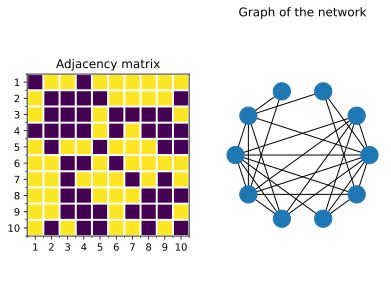

In [3]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

fig = network_graph.plot_graph()


We now create the multi-channel signal $\mathbf{y}$ measured at the nodes and the global signal $\mathbf{d}.$ We consider that the total signal samples of $\mathbf{y}$ and $\mathbf{d}$ consist of blocks of 10000 samples each, which we will generate synthetically. We choose the number of filters (i.e., the number of columns of $X$ or the dimension of the filtered signal $X^T\mathbf{y}$) to be equal to 5.

We use the class **`ProblemInputs`** to put all inputs of the problem in a standard format, to be used by both the centralized and DASF solvers. Since we have one signal $\mathbf{y}$ to be fused with $X$ through $X^T\mathbf{y}$ and one target $\mathbf{d}$ that is not fused, in **`ProblemInputs`**, `fused_data` and `global_parameters` will have one element while the other attributes will be empty. The attribute `fused_data[0]` will consist of the matrix `Y` containing in its columns time samples of $\mathbf{y}$:
$Y = [\mathbf{y}(1);\dots;\mathbf{y}(10000)]$, while `global_parameters[0]` will be $D = [\mathbf{d}(1);\dots;\mathbf{d}(10000)]$.

In [4]:
# Number of samples of the signals
nb_samples = 10000

# Number of filters of X
nb_filters = 5

mmse_inputs = mmse_generate_synthetic_inputs(nb_samples=nb_samples, nb_sensors=network_graph.nb_sensors_total, rng=rng, nb_sources=nb_filters)

When solving the MMSE problem in the DASF setting, we need to use a centralized solver to
solve the local problems created at each different node, where each node solves a parameterized
version of the original problem. The solver we use is **`MMSEProblem`**`.solve` which solves:

$\text{min}_X\; \mathbb{E}[||\mathbf{g}_1(t)-X^T\mathbf{y}_1(t)||^2].$

Comparing it with problem $P$, we see that we have $\mathbf{y}_1=\mathbf{y}$ and
$\mathbf{g}_1=\mathbf{d}$.

The inputs of the problem are stored in the class **`ProblemInputs`** (see documentation for
more information).

The optimal filter $X^*$ is estimated using the centralized solver **`MMSEProblem`**`.solve` taking
as input `mmse_inputs`.

In [5]:
mmse_problem = MMSEProblem(nb_filters=nb_filters)
X_star = mmse_problem.solve(problem_inputs=mmse_inputs, save_solution=True)
f_star = mmse_problem.evaluate_objective(X_star, problem_inputs=mmse_inputs)

For the distributed context, we take the previously created network, and choose a randomly
generated sequence as the updating path, i.e., the order in which the nodes take turns
in solving their local problem.

We also fix the number of iterations of the DASF algorithm to be equal to 500. We do not specify the other stopping conditions for the DASF algorithm, namely reaching a certain threshold on $\|X^{i+1}-X^i\|_F$ or $|f(X^{i+1})-f(X^i)|$, therefore DASF algorithm will make exactly 500 iterations.

In [6]:
max_iterations = 500
dasf_convergence_parameters = ConvergenceParameters(max_iterations=max_iterations)

Initially, we will simulate a stationary setting, therefore, we will keep the same window of `Y` for all iterations, which can be done by setting `window_length`of **`DataParameters`** equal to `nb_samples`, `nb_window_reuse` to `max_iterations` and `sliding_window_offset` to 0.

In [7]:
mmse_data_params = DataParameters(nb_samples=nb_samples, window_length=nb_samples, nb_window_reuse=max_iterations, sliding_window_offset=0)

We build the DASF solver as follows. `update_path` provides a predetermined seuqence of updating nodes to the DASF algorithm which will be used to sequentially select the updating nodes.

In [27]:
update_path = rng.permutation(range(nb_nodes))
dasf_mmse_stationary_solver = DASF(problem=mmse_problem, problem_inputs=mmse_inputs, network_graph=network_graph, dasf_convergence_params=dasf_convergence_parameters, data_params=mmse_data_params, updating_path=update_path, rng=rng)

The DASF algorithm is then called by using the `run` method. Each node $q$ will solve a parameterized/compressed version of the problem $P$
given by:

$\text{min}_{\widetilde{X}_q}\; \mathbb{E}[||\mathbf{d}(t)-\widetilde{X}_q^TC_q^T\mathbf{y}(t)||^2],$

which is again an MMSE problem, where the inputs are compressed versions of the original one.

In [28]:
dasf_mmse_stationary_solver.run()

Let us look at the plot of the normalized error $\frac{||X^i-X^*||_F^2}{||X^*||_F^2}$:

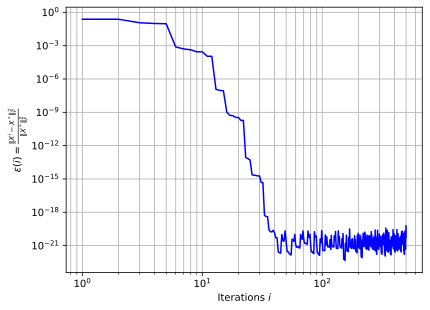

In [30]:
fig = dasf_mmse_stationary_solver.plot_error()

Let's now look at a non-stationary setting. For this purpose, we will generate synthetic data with changing statistics in time.

In [ ]:
mmse_nonstationary_inputs=mmse_generate_non_stationary_inputs(nb_samples_per_window=nb_samples, nb_sensors=network_graph.nb_sensors_total, rng=rng, nb_sources=nb_filters, nb_windows=500)

In [86]:
mmse_data_params = DataParameters(nb_samples=nb_samples*10, window_length=nb_samples, nb_window_reuse=1)

In [87]:
mmse_nonstationary_inputs.fused_data[0].shape

(50, 100000)

In [88]:
dasf_mmse_nonstationary_solver = DASF(problem=mmse_problem, problem_inputs=mmse_nonstationary_inputs, network_graph=network_graph, dasf_convergence_params=dasf_convergence_parameters, data_params=mmse_data_params, updating_path=update_path, rng=rng)

In [89]:
dasf_mmse_nonstationary_solver.run()

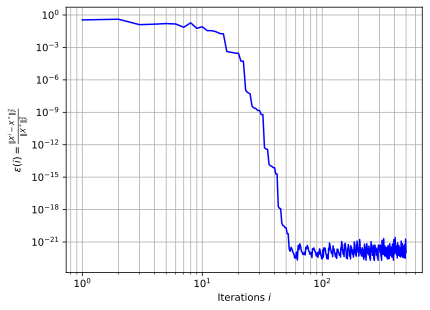

In [90]:
fig = dasf_mmse_nonstationary_solver.plot_error()